# Iterative Closest Point - Exercise - ATP - 2025

## Overview
Having two scans $P = \{p_i\}$ and $Q = \{q_i\}$ we want to find a transformation (rotation $R$ and translation $t$) to apply to $P$ to match $Q$ as good as possible. In the this notebook we will try to find such a transformation using various means


Import libraries

In [350]:
import open3d as o3d
import numpy as np
from math import pi, sin, cos
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R
import sys
from datetime import datetime
import time
import copy
import glob

# 2) Create a coordinate frame at the origin,  with a given size (length of the axes)
COOR_FRAME = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=5.0,      # axis length
        origin=[0, 0, 0]  # where to place the origin
        )

pc_P = None
pc_Q = None
pc_P_aligned = None


Define a simple function to transform a numpy point array to an open3D point cloud object so it can be use with the open3D library

In [3]:


def to_open3d_pointcloud(array, color):
    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(array.T)
    pc.paint_uniform_color(color)
    return pc


In [341]:
def vis_originalPCs_after_loading():
    o3d.visualization.draw_geometries([pc_Q.paint_uniform_color([0, 0, 1]),
                                       pc_P.paint_uniform_color([1, 0, 0]),
                                       COOR_FRAME])

This is just for convenience to get Angles in Degrees instead of radians for better interpretation

In [4]:
def rotation_matrix_to_euler_deg(R_mat, order='xyz'):
    """Convert 3×3 R to Euler angles (deg) in given axis order."""
    return R.from_matrix(R_mat).as_euler(order, degrees=True)


In [25]:
def create_xy_grid(min_bound, max_bound, step=1.0, color=(0.7,0.7,0.7)):
    """
    Create a LineSet representing a grid in the XY plane at z = min_bound[2].
    """
    x0, y0, z0 = min_bound
    x1, y1, _  = max_bound

    points = []
    lines  = []

    idx = 0
    # vertical lines (parallel to Y)
    xs = np.arange(x0, x1 + 1e-6, step)
    for x in xs:
        points.append([x, y0, z0])
        points.append([x, y1, z0])
        lines.append([idx, idx+1])
        idx += 2

    # horizontal lines (parallel to X)
    ys = np.arange(y0, y1 + 1e-6, step)
    for y in ys:
        points.append([x0, y, z0])
        points.append([x1, y, z0])
        lines.append([idx, idx+1])
        idx += 2

    grid = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines =o3d.utility.Vector2iVector(lines)
    )
    colors = np.tile(np.array(color), (len(lines),1))
    grid.colors = o3d.utility.Vector3dVector(colors)
    return grid

Define a function to find correspondences 

In [5]:
# Get correspondences by nearest neighbors
def get_correspondence_indices(P, Q, max_iter=5000):
    p_size = P.shape[1]
    q_size = Q.shape[1]
    correspondences = []
    for i in range(p_size):
        p_point = P[:, i]
        min_dist = sys.maxsize
        chosen_idx = -1
        for j in range(q_size):
            q_point = Q[:, j]
            dist = np.linalg.norm(q_point - p_point)
            if dist < min_dist:
                min_dist = dist
                chosen_idx = j
        correspondences.append((i, chosen_idx))
        if i> max_iter:
            break
    return correspondences




A small helper function to draw the individual point cloud transformation during the SVD step. Use within compute_icp_svd_total() function


In [ ]:
def drawIterations(newP):
    pc_aligned = to_open3d_pointcloud(newP, [0, 1, 0])  # green
        
    o3d.visualization.draw_geometries([pc_Q, pc_P, pc_aligned, COOR_FRAME])

helper function to draw the original and shifted point clouds as well as their point correspondences

In [45]:
def visualize_pcs_cooresponds(P, Q, correspondences):
    """
    Visualize point clouds P and Q with correspondences.
    """
    pc_P = to_open3d_pointcloud(P, [1, 0, 0])  # red
    pc_Q = to_open3d_pointcloud(Q, [0, 0, 1])  # blue

    # Create axis-aligned bounding boxes for both point clouds
    bboxP = pc_P.get_axis_aligned_bounding_box()
    bboxQ = pc_Q.get_axis_aligned_bounding_box()

    # use the built-in union operator --- #
    minb = np.minimum(bboxP.min_bound, bboxQ.min_bound)
    maxb = np.maximum(bboxP.max_bound, bboxQ.max_bound)

    # make a 1 m XY-grid
    grid = create_xy_grid(minb, maxb, step=1.0)

    # optional: draw a little coordinate frame at the origin
    coord = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=1.0, origin=[0,0,0])


    # Create lines for correspondences
    lines = []
    colors = []
    for i, j in correspondences:
        lines.append([i, j + P.shape[1]])  # Offset Q points in concatenated array
        colors.append([0.5, 0.5, 0.5])     # gray

    # Combine point clouds for correspondence visualization
    merged_points = np.hstack((P, Q)).T
    line_set = o3d.geometry.LineSet()
    line_set.points = o3d.utility.Vector3dVector(merged_points)
    line_set.lines = o3d.utility.Vector2iVector(lines)
    line_set.colors = o3d.utility.Vector3dVector(colors)

    # Visualize
    o3d.visualization.draw_geometries([pc_P, pc_Q, line_set, grid, coord],)

### Caclulate the SVD for the two Point clouds to find out the Rotation matrix and translation vector.
Take note that this is a very naive implementation for the nearest neighbourhood search within the point clouds and it compares every point $p_i$ from point cloud $P$ with every point $q_i$ in the other point cloud $Q$. Thhat has an $O(N^2)$ time complexity due to the double loop over all our points for every iteration, whereas everything else (centroid-computing, SVD on a 3×3 matrix, vector updates) is at most $O(N)$ or even constant time.
We can use also a KDTree That slashes the per-iteration cost to roughly $O(NlogN)$. This is often done in practice and implemented using the FLANN Library - Fast Library for Approximate Nearest Neighbors: e.g. https://github.com/flann-lib/flann


In [105]:

def compute_icp_svd_total(P_init, Q, max_iterations=20, tol=1e-6, doVis=False):
    """
    ICP via SVD in 3D, returning:
      R_tot: 3×3 overall rotation
      t_tot: 3×1 overall translation
      P_aligned: transformed P_init
    """
    # Path to your log
    log_path = "icp_iterations.log"
    now = datetime.now().strftime("%d.%m.%Y %H:%M:%S")

    # 1) Clear or (re)create the file
    with open(log_path, "w") as f:
        f.write(f"ICP Iterations Log\n")
        f.write(f"Created: {now}\n")
        f.write("="*40 + "\n\n")
    
    P_curr = P_init.copy()
    R_tot = np.eye(3)
    t_tot = np.zeros((3,1))

    f = open(log_path, "w")
    for i in range(max_iterations):
        # 1) find correspondences
        
        t0 = time.perf_counter()        
        corr = get_correspondence_indices(P_curr, Q)
        t1 = time.perf_counter()
        print(f"correspondence search took {t1-t0:.4f} s")
        

        P_corr = np.stack([P_curr[:, i] for i, _ in corr], axis=1)
        Q_corr = np.stack([Q[:, j]      for _, j in corr], axis=1)

        # 2) centroids
        mu_P = P_corr.mean(axis=1, keepdims=True)
        mu_Q = Q_corr.mean(axis=1, keepdims=True)

        # 3) centered
        Pc = P_corr - mu_P
        Qc = Q_corr - mu_Q

        # 4) SVD on covariance
        
        
        t2 = time.perf_counter()        
        H = Pc @ Qc.T
        U, _, Vt = np.linalg.svd(H)        
        t3 = time.perf_counter()
        print(f"SVD took {t3-t2:.6f} s")

        Rk = Vt.T @ U.T
        if np.linalg.det(Rk) < 0:         # prevent reflection
            Vt[2,:] *= -1
            Rk = Vt.T @ U.T

        # 5) translation for this step
        tk = mu_Q - Rk @ mu_P

        # 6) update cumulative
        R_tot = Rk @ R_tot
        t_tot = Rk @ t_tot + tk

        # 7) apply to P_curr
        P_new = Rk @ P_curr + tk

        # 8) check convergence
        if np.linalg.norm(P_new - P_curr) < tol:
            P_curr = P_new
            print(f"Converged after {i} iterations: tolerance < {tol:.6f} reached")
            break
        P_curr = P_new
        
        
        ########################################
        ### here the acutual SVD function ends, the rest is for visualization and logging
        
        ### this is for visualization only
        if i==0:
            tmp = P
            offset = 0.05
            offset_for_vis = np.array([[offset],[offset],[offset]]) # offset for better visualization
            tmp = P + offset_for_vis # apply a small offset to the original data for better visualization
            
        ###
        R_est_inv = R_tot.T
        t_est_inv = -R_est_inv @ t_tot
        
        # this is also part of the step wise visualization
        ## change the following lint to visualize the iterations True or False  and recompile / rerun the cell
        if doVis:
            drawIterations(tmp)
            tmp = R_est_inv @ P + t_est_inv
            
        ###
        ## this is for logging the iterations
        ###
        angles_true_deg = rotation_matrix_to_euler_deg(R_est_inv, order='xyz')
        # 2) Append the values to file
        
        f.write(f"Iteration {i}\n")
        f.write("R_est_inv:\n")
        # write matrix row by row
        for row in R_est_inv:
            f.write("  " + "  ".join(f"{val: .6f}" for val in row) + "\n")
        f.write("t_est_inv: " + "  ".join(f"{val: .6f}" for val in t_est_inv.ravel()) + "\n")
        f.write("angles (deg, xyz): " + ", ".join(f"{a: .4f}" for a in angles_true_deg) + "\n")
        f.write("\n")
    
    f.close()
    print("max iterations reached, with tolerance np.linalg.norm(P_new - P_curr) > tol = ", np.linalg.norm(P_new - P_curr) , " > ", tol)
    print("log file written to: ", log_path)
    return R_tot, t_tot, P_new

Generate 3D Point cloud data for point clouds $Q$ and $P$, let $P = R*Q+t$

In [41]:


# Generate 3D data: x, y (as before), plus z (new)
num_points = 30
x = np.linspace(0, 10, num_points)
y = 0.2 * x * np.sin(0.5 * x)
z = 0.1 * x * np.cos(0.5 * x)

Q = np.vstack((x, y, z))

# 3D rotation matrix for rotation around z-axis 
angle = pi / 4
Rz = np.array([[cos(angle), -sin(angle), 0],
               [sin(angle),  cos(angle), 0],
               [0,           0,          1]])

# 3D translation
t = np.array([[1], [2], [3]])

# print out the original rotation of the data
original_rotation = rotation_matrix_to_euler_deg(Rz, 'xyz')
print("original rotation (deg):", original_rotation, " deg")    # ≈ [0,0,45]
print("original translation [x,y,z] =", t.ravel(), "m")     # ≈ [1,2,3]

# Apply transformation
P = Rz @ Q + t

# determine the correspondences between P and Q
# P is the moved data, Q is the true data
correspondences = get_correspondence_indices(P, Q)






original rotation (deg): [ 0.  0. 45.]  deg
original translation [x,y,z] = [1 2 3] m


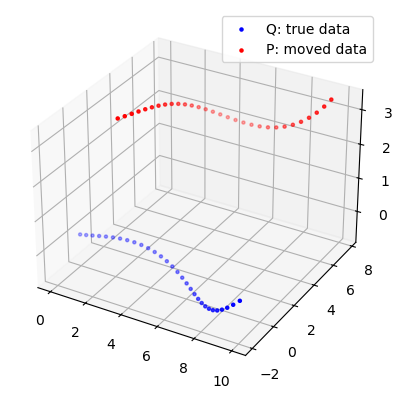

In [42]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*Q, label='Q: true data', color='blue', marker='.')
ax.scatter(*P, label='P: moved data', color='red', marker='.')
ax.legend()
plt.show()

Transform our point clouds (PC) to open3d PCs, so we can visualize them
! New window will open maybe behind this window !

In [ ]:
# convert 3d Point array to open3d point cloud object
pc_P = to_open3d_pointcloud(P,[1, 0, 0]) # red
pc_Q = to_open3d_pointcloud(Q, [0, 0, 1])# blue

visualize_pcs_cooresponds(P, Q, correspondences)



Now that we have found the correspondences and have visualized our simple point clouds and their correspondences (connections), we can find a transformation that minimized the distance between the two point clouds using SVD

In [47]:
# R_tot, t_tot from compute_icp_svd_total(P, Q)
R_true_est, t_true_est, p_aligned = compute_icp_svd_total(Q, P,doVis=True)
R_est_inv = R_true_est.T
t_est_inv = -R_est_inv @ t_true_est

offset = 0.05
offset_for_vis = np.array([[offset],[offset],[offset]]) # offset for better visualization

# P is the moved data, Q is the true data
# p_aligned is the corrected data after ICP and applying the inverse of the estimated transformation
# p_aligned = R_est_inv @ P + t_est_inv
p_aligned = R_est_inv @ p_aligned + t_est_inv + offset_for_vis

# getting the angles in degrees for better interpration
angles_true_deg = rotation_matrix_to_euler_deg(R_est_inv, order='xyz')
print("Recovered rotation (deg):", angles_true_deg)    # ≈ [0,0,45]
print("Recovered translation:", t_est_inv.ravel())     # ≈ [1,2,3]




correspondence search took 0.0056 s
SVD took 0.000368 s
correspondence search took 0.0046 s
SVD took 0.000175 s
correspondence search took 0.0045 s
SVD took 0.000182 s
correspondence search took 0.0042 s
SVD took 0.000143 s
correspondence search took 0.0050 s
SVD took 0.000143 s
correspondence search took 0.0051 s
SVD took 0.000175 s
correspondence search took 0.0048 s
SVD took 0.000786 s
correspondence search took 0.0041 s
SVD took 0.000144 s
correspondence search took 0.0041 s
SVD took 0.000201 s
correspondence search took 0.0043 s
SVD took 0.000162 s
correspondence search took 0.0043 s
SVD took 0.000126 s
correspondence search took 0.0042 s
SVD took 0.000146 s
correspondence search took 0.0061 s
SVD took 0.001014 s
correspondence search took 0.0038 s
SVD took 0.000236 s
correspondence search took 0.0033 s
SVD took 0.000216 s
correspondence search took 0.0049 s
SVD took 0.000188 s
correspondence search took 0.0042 s
SVD took 0.000158 s
correspondence search took 0.0041 s
SVD took 0.0

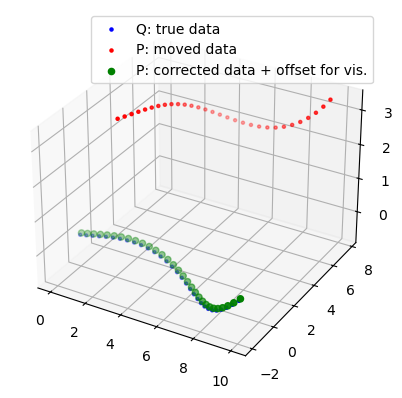

In [48]:
# Plotting


fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(*Q, label='Q: true data', color='blue', marker='.')
ax.scatter(*P, label='P: moved data', color='red', marker='.')
ax.scatter(*p_aligned, label='P: corrected data + offset for vis.', color='green', marker='o')
ax.legend()
plt.show()


In [49]:
pc_aligned = to_open3d_pointcloud(p_aligned, [0, 1, 0])  # green
o3d.visualization.draw_geometries([pc_Q, pc_P, pc_aligned])

# Apply our simple ICP Method to real world data
### load the pcd files into an array then process them using our methods defined above

Read in PCD files. The point clouds were created with the iphone 12 Lidar scanner and colorized using the rgb camera of the iPhone

In [281]:
def read_pcd_files(voxel_size=0.2):
    # 1) Gather all .pcd file paths in a directory
    # pcd_paths = glob.glob("vlp16/*.xyz")  # adjust your folder
    pcd_paths = glob.glob("*.xyz")  # adjust your folder


    # 2) Read them into a list of PointCloud objects
    pcd_list = [o3d.io.read_point_cloud(p) for p in pcd_paths]
    downsampled_clouds = []


    # Now pcd_list[i] is the i-th Open3D point cloud,        
    for i, pcd in enumerate(pcd_list):
        print(f"Cloud #{i} has {len(pcd.points)} points")
        # uniform (voxel) down‐sampling at, say, 20 cm grid be default
        
        if voxel_size > 0:
            pcd_ds = pcd.voxel_down_sample(voxel_size)
        else:
            pcd_ds = pcd
        downsampled_clouds.append(pcd_ds)
        print(f" → {len(pcd.points)} pts  → {len(pcd_ds.points)} pts after downsample")

    return downsampled_clouds



In [282]:
downsampled_clouds = read_pcd_files()
pc_Q = downsampled_clouds[0]
pc_P = downsampled_clouds[1]
o3d.visualization.draw_geometries([pc_Q.paint_uniform_color([0, 0, 1]),
                                   pc_P.paint_uniform_color([1, 0, 0]),
                                   COOR_FRAME])

Cloud #0 has 44826 points
 → 44826 pts  → 5430 pts after downsample
Cloud #1 has 35469 points
 → 35469 pts  → 428 pts after downsample


Draw correspondences as lines

In [122]:
P = np.asarray(pc_P.points).T
Q = np.asarray(pc_Q.points).T
correspondences = get_correspondence_indices(Q, P)
visualize_pcs_cooresponds(P, Q, correspondences)



In [111]:
R_true_est, t_true_est, p_aligned = compute_icp_svd_total(Q, P, max_iterations=10, doVis=False)

correspondence search took 6.7079 s
SVD took 0.000208 s
correspondence search took 6.7411 s
SVD took 0.000350 s
correspondence search took 6.7050 s
SVD took 0.000249 s
correspondence search took 6.6894 s
SVD took 0.000207 s
correspondence search took 6.6943 s
SVD took 0.000257 s
correspondence search took 6.6680 s
SVD took 0.000223 s
correspondence search took 6.7226 s
SVD took 0.000229 s
correspondence search took 6.6938 s
SVD took 0.000252 s
correspondence search took 6.7549 s
SVD took 0.000274 s
correspondence search took 6.7347 s
SVD took 0.000205 s
max iterations reached, with tolerance np.linalg.norm(P_new - P_curr) > tol =  0.0  >  1e-06
log file written to:  icp_iterations.log


Invert the transformations and apply to the aligned point cloud. If the transformation was calculated well, the inversed transformation should put the aligned point cloud back to where it originally was (or very close to it)

In [112]:
R_est_inv = R_true_est.T
t_est_inv = -R_est_inv @ t_true_est

offset = 0.05
offset_for_vis = np.array([[offset],[offset],[offset]]) # offset for better visualization

# P is the moved data, Q is the true data
# p_aligned is the corrected data after ICP and applying the inverse of the estimated transformation
# p_aligned = R_est_inv @ P + t_est_inv
p_aligned = R_est_inv @ p_aligned + t_est_inv + offset_for_vis

# getting the angles in degrees for better interpration
angles_true_deg = rotation_matrix_to_euler_deg(R_est_inv, order='xyz')
print("Recovered rotation (deg):", angles_true_deg)    # ≈ [0,0,45]
print("Recovered translation:", t_est_inv.ravel())     # ≈ [1,2,3]

Recovered rotation (deg): [ 24.83892832 -29.28487814 -27.68813607]
Recovered translation: [-1.30421769 -3.16779642  1.63449215]


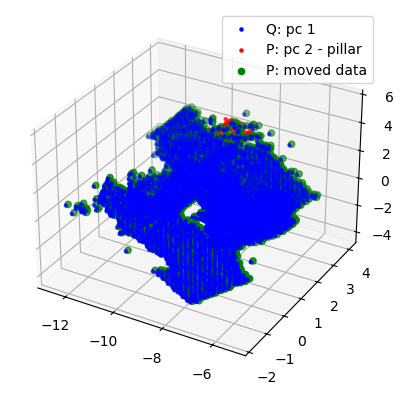

In [123]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*Q, label='Q: pc 1', color='blue', marker='.')
ax.scatter(*P, label='P: pc 2 - pillar', color='red', marker='.')
ax.scatter(*p_aligned, label='P: moved data', color='green', marker='o')
ax.legend()
plt.show()

In [207]:
pc_aligned = to_open3d_pointcloud(p_aligned, [0, 1, 0])  # green
o3d.visualization.draw_geometries([pc_Q, pc_P, pc_aligned, COOR_FRAME])

In [208]:
o3d.visualization.draw_geometries([pc_P, pc_aligned, COOR_FRAME])

# Implement the standard ICP using open3d library



define a function for it so we can use it later

In [339]:
def runOpen3DICP(pc_P, pc_Q, pt2Plane=False):
  
    # Run point-to-point or point to plance - ICP
    threshold = 0.1  # max correspondence distance (m)
    trans_init = np.eye(4)  # identity as starting guess

 
    reg = None
    
    if pt2Plane:
        print("\nUsing point-to-plane ICP, estimate normals first...")
           # Estimate normals for the target point cloud (pc_P)
        pc_P.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
        pc_Q.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
        reg = o3d.pipelines.registration.registration_icp(
        pc_Q, pc_P, threshold, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPlane(),    #TransformationEstimationPointToPlane()   or #TransformationEstimationPointToPoint()
        o3d.pipelines.registration.ICPConvergenceCriteria(
            max_iteration=50))
    else:
        print("\nUsing point-to-point ICP")
        reg = o3d.pipelines.registration.registration_icp(
        pc_Q, pc_P, threshold, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),    #TransformationEstimationPointToPlane()   or #TransformationEstimationPointToPoint()
        o3d.pipelines.registration.ICPConvergenceCriteria(
            max_iteration=50))

    print("Fitness:", reg.fitness)
    print("Inlier RMSE:", reg.inlier_rmse)
    print("Estimated transformation:\n", reg.transformation)
    return reg

read original point clouds again

In [340]:

# start be reading the point clouds again and downsampling them
downsampled_clouds = read_pcd_files(voxel_size=-1)
# assign the point clouds to Q and P
pc_Q = downsampled_clouds[0]
pc_P = downsampled_clouds[1]



Cloud #0 has 44826 points
 → 44826 pts  → 44826 pts after downsample
Cloud #1 has 35469 points
 → 35469 pts  → 35469 pts after downsample


### Apply transformation and visualzie the result and then analize the result


In [303]:

reg = runOpen3DICP(pc_P, pc_Q, pt2Plane=False)
# The above function will run the ICP algorithm using Open3D's built-in functions.


Using point-to-point ICP
Fitness: 0.0017177530897247134
Inlier RMSE: 0.06778440074868487
Estimated transformation:
 [[ 0.97396093 -0.22106995  0.05028111  0.06806394]
 [ 0.22227393  0.97478527 -0.01969703  1.73740199]
 [-0.04465886  0.03036031  0.99854085 -0.32229975]
 [ 0.          0.          0.          1.        ]]


In [304]:
# Transform source and visualize result
T = reg.transformation

offset = 0.05
offset_for_vis = np.array([[offset],[offset],[offset]]) # offset for better visualization
pc_P_aligned = copy.deepcopy(pc_P)

pc_aligned = pc_P_aligned.transform(reg.transformation).translate(offset_for_vis)

o3d.visualization.draw_geometries(
    [ pc_P_aligned.paint_uniform_color([0, 1, 0]),  # green
    pc_P.paint_uniform_color([0, 0, 1]),  # blue
    pc_Q.paint_uniform_color([1, 0, 0]),   # red
    COOR_FRAME],
    window_name="After ICP")

create original transformation but inverse of the translated and rotated pillar point cloud. $t=[-1,-2,-3]$


In [299]:
### create a transformation matrix for the point cloud the is the inverse of the original transformation
# angle in radians

theta = np.deg2rad(-15)

# 1) build 3×3 rotation about Z
Rz = np.array([
    [ np.cos(theta), -np.sin(theta), 0],
    [ np.sin(theta),  np.cos(theta), 0],
    [             0,              0, 1],
])

# 2) create full 4×4 transform
Torig = np.eye(4)
Torig[:3, :3] = Rz
# 2) create full 4×4 transform without rotation

Torig[:3,  3] = [0, -1, -3]
print("Transformation matrix:\n", Torig)



Transformation matrix:
 [[ 0.96592583  0.25881905  0.          0.        ]
 [-0.25881905  0.96592583  0.         -1.        ]
 [ 0.          0.          1.         -3.        ]
 [ 0.          0.          0.          1.        ]]


Apply a pre translation and rotation (from previous cell) so that point clouds partly overlap

In [300]:
offset = 0.05
offset_for_vis = np.array([[offset],[offset],[offset]]) # offset for better visualization
pc_P_aligned = copy.deepcopy(pc_P)  # make a copy of the original point cloud and save it in a new block of memory, so that the original data is not changed

pc_aligned = pc_P_aligned.transform(Torig)  #translate(np.array([[-1],[-2],[-3]]))

o3d.visualization.draw_geometries(
    [ pc_P_aligned.paint_uniform_color([0, 1, 0]),  # green
    pc_P.paint_uniform_color([0, 0, 1]),  # blue
    pc_Q.paint_uniform_color([1, 0, 0]),  # red
    COOR_FRAME],
    window_name="After ICP")

now re-apply the ICP from open3D by calling the library with the pc_Q and pc_P_aligned point clouds

In [301]:
reg = runOpen3DICP(pc_P_aligned, pc_Q, pt2Plane=True)

# Transform source and visualize result
T = reg.transformation


offset = 0.1
offset_for_vis = np.array([[offset],[offset],[offset]]) # offset for better visualization
pc_P_aligned_new = copy.deepcopy(pc_P_aligned)

pc_aligned_new = pc_P_aligned_new.transform(reg.transformation).translate(offset_for_vis)

o3d.visualization.draw_geometries(
    [ pc_P_aligned.paint_uniform_color([0, 1, 0]),  # green
     pc_P_aligned_new.paint_uniform_color([0, 1, 1]),  # cyan
    pc_P.paint_uniform_color([0, 0, 1]),  # blue
    pc_Q.paint_uniform_color([1, 0, 0]),   # red
    COOR_FRAME],
    window_name="After ICP")


Using point-to-plane ICP, estimate normals first...
Fitness: 0.07207870432338374
Inlier RMSE: 0.058552988933183635
Estimated transformation:
 [[ 0.97617167  0.12051904  0.18045505 -0.94969779]
 [-0.12387364  0.99227045  0.00739494 -0.68174543]
 [-0.17816898 -0.02957236  0.98355543 -1.14858735]
 [ 0.          0.          0.          1.        ]]


## Apply the GICP from Open3D to the point clouds

But first load the original point cloud files and apply a pre translation

In [352]:
# start be reading the point clouds again and downsampling them
downsampled_clouds = read_pcd_files(voxel_size=0)
# assign the point clouds to Q and P
pc_Q = downsampled_clouds[0]
pc_P = downsampled_clouds[1]

Torig = np.eye(4)

# 2) create full 4×4 transform without rotation

Torig[:3,  3] = [0, -1, -3]
print("Transformation matrix:\n", Torig)

pc_P = pc_P.transform(Torig)  #translate(np.array([[-1],[-2],[-3]]))

vis_originalPCs_after_loading()

Cloud #0 has 44826 points
 → 44826 pts  → 44826 pts after downsample
Cloud #1 has 35469 points
 → 35469 pts  → 35469 pts after downsample
Transformation matrix:
 [[ 1.  0.  0.  0.]
 [ 0.  1.  0. -1.]
 [ 0.  0.  1. -3.]
 [ 0.  0.  0.  1.]]


In [353]:
def runOpen3DGICP(pc_P, pc_Q):
    # 3) Run Generalized ICP
    distance_threshold = 2.1  # maximum correspondence distance (m)
    trans_init = np.eye(4)    # initial guess

    result_gicp = o3d.pipelines.registration.registration_generalized_icp(
        pc_Q, pc_P,
        max_correspondence_distance=distance_threshold,
        init=trans_init,
        estimation_method=o3d.pipelines.registration.TransformationEstimationForGeneralizedICP(),
        criteria=o3d.pipelines.registration.ICPConvergenceCriteria(
            max_iteration=50)
    )

    
    print("Fitness:", result_gicp.fitness)
    print("Inlier RMSE:", result_gicp.inlier_rmse)
    print("Estimated transformation:\n", result_gicp.transformation)
    return result_gicp



In [364]:
result_gicp = runOpen3DGICP(pc_Q, pc_P)
source_aligned = copy.deepcopy(pc_Q)
source_aligned = pc_Q.transform(result_gicp.transformation)
o3d.visualization.draw_geometries([
    source_aligned.paint_uniform_color([0, 1, 0]),  # green
    pc_P.paint_uniform_color([1, 0, 0]),  # green
    pc_Q.paint_uniform_color([0, 0, 1])],         # blue
    window_name="After GICP"
)

Fitness: 1.0
Inlier RMSE: 0.2396200320065664
Estimated transformation:
 [[ 0.73780159 -0.61601074  0.2760065  -1.79743635]
 [ 0.67038659  0.6208731  -0.40632303  7.22375497]
 [ 0.07893434  0.48481683  0.8710465   0.80974205]
 [ 0.          0.          0.          1.        ]]


In [366]:
def preprocess_point_cloud(pcd, voxel_size):
    pcd_down = pcd.voxel_down_sample(voxel_size)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(
            radius=voxel_size*6, max_nn=30))
    radius_feature = 3 # radius for FPFH feature in meters
    fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(
            radius=radius_feature, max_nn=100))
    return pcd_down, fpfh


def execute_global_registration(src_down, tgt_down, src_fpfh, tgt_fpfh, voxel_size):
    ## Play with this value to get a good result ()
    distance_threshold = 5  # max correspondence distance (m)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        src_down, tgt_down, src_fpfh, tgt_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        4,  # RANSAC correspondence set size
        [   # RANSAC criteria
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)
        ],
        o3d.pipelines.registration.RANSACConvergenceCriteria(4000000, 500)
    )
    return result

In [367]:
# --- Load and preprocess --- #
voxel_size = 0.05
# start be reading the point clouds again and downsampling them
downsampled_clouds = read_pcd_files(voxel_size=0)
# assign the point clouds to Q and P
pc_Q = downsampled_clouds[0]
pc_P = downsampled_clouds[1]

src_down, src_fpfh = preprocess_point_cloud(pc_Q, voxel_size)
tgt_down, tgt_fpfh = preprocess_point_cloud(pc_P, voxel_size)

# --- Stage 1: global (RANSAC) registration via FPFH --- #
result_ransac = execute_global_registration(
    src_down, tgt_down, src_fpfh, tgt_fpfh, voxel_size)
print("Global registration result:")
print(result_ransac)
init_trans = result_ransac.transformation

# --- Stage 2: refine with GICP --- #
result_gicp = o3d.pipelines.registration.registration_generalized_icp(
    pc_Q, pc_P,    
    max_correspondence_distance= 6.0,
    
    init=init_trans,
    estimation_method=o3d.pipelines.registration.TransformationEstimationForGeneralizedICP(),
    criteria=o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=50)
)
print("GICP refinement result:")
print(result_gicp.transformation)

# --- Visualize final alignment --- #
aligned = pc_Q.transform(result_gicp.transformation)
o3d.visualization.draw_geometries([
    aligned.paint_uniform_color([0,1,0]),
    pc_P.paint_uniform_color([0,0,1])
])

Cloud #0 has 44826 points
 → 44826 pts  → 44826 pts after downsample
Cloud #1 has 35469 points
 → 35469 pts  → 35469 pts after downsample
[Open3D WARNING] Too few correspondences (2035) after mutual filter, fall back to original correspondences.
Global registration result:
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
GICP refinement result:
[[ 0.18000791  0.98009161 -0.08377107 -7.94402106]
 [-0.58088606  0.03718723 -0.81313498 -3.70315191]
 [-0.79383156  0.19503217  0.57601555 -2.67111164]
 [ 0.          0.          0.          1.        ]]
